In [1]:
# import packages used in the notebook
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
import os
import requests
import json
import io
from fiona.crs import from_epsg
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib 
import zipfile 

# Make sure the environmental variable works
puidata = os.getenv("PUIDATA")
if not puidata or puidata == 'nfshome/tm1722/PUIdata':
    puidata = '/nfshome/tm1722/PUIDATA'
    
os.environ["PUIDATA"] = puidata

%matplotlib inline



# 1. PUMA : Public Use Microdata Area


## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas


In [2]:
# Download the shapefile 
urllib.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', puidata + '/puma2.gz')
zip_ref = zipfile.ZipFile(puidata + '/puma2.gz', 'r')
zip_ref.extractall(puidata)
zip_ref.close()


In [3]:
# Read the shape file in a geopandas dataframe
pumashp = gpd.GeoDataFrame.from_file(puidata + '/geo_export_c0d36762-2ce4-4c96-ac35-cfeb8e0a58a2.shp')

In [4]:
# Check out data in the df
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [5]:
# Check out the epsg for the imported geodata
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions

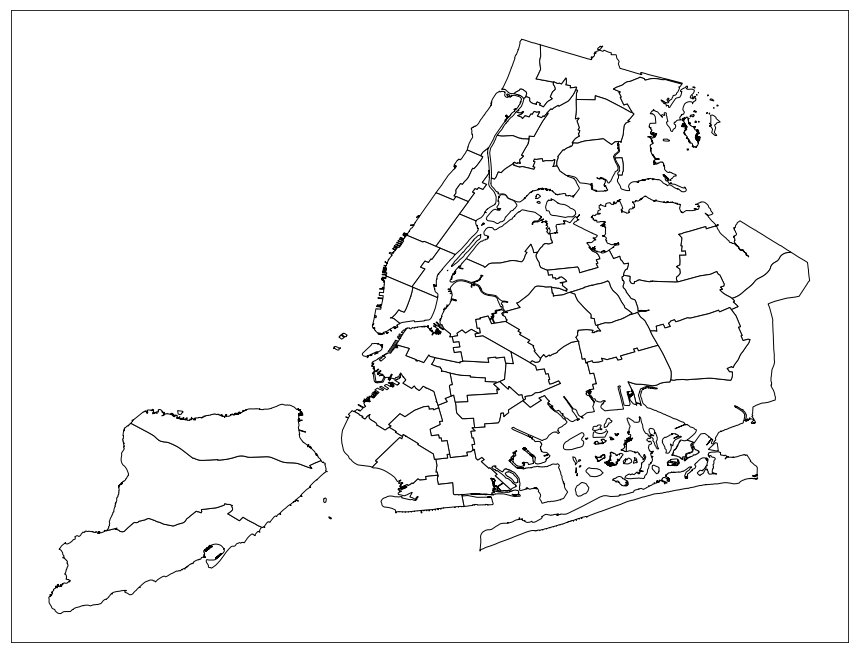

In [6]:
plot1 = pumashp.plot(color="white", edgecolor="black", figsize=(15,15), lw=1)
plot1.get_xaxis().set_visible(False)
plot1.get_yaxis().set_visible(False)

## Figure 1. Plot of PUMA NYC regions

This graph shows the geographical boundaries of the PUMA region in NYC.

# 2. American Fact Finder data on percentage of houses with broadband internet access


## 2.1 Get data with American Fact Finder (AFF) API: 


In [7]:
# Attempt to get the API key from an environmental variable created in the ADRF bash
# (did not work!)

# myAPI = os.getenv('KEY')

In [8]:
cd /nfshome/tm1722

/nfshome/tm1722


In [9]:
# import the API key from the separate file
from censusAPI import myAPI

In [10]:
# Read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [11]:
# Turn things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))


Below, importing two features: **total number of households**, and **number of households with broadband access** using list comprehesion.

- Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

- The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

- is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [12]:
# Extract variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [13]:
# Keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [14]:
# Keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [15]:
# Use the variable names use them to extract the relevant data with the ACS API. 
# Get the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [16]:
# Get the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [17]:
pumaBB['percentage_w_bb_access'] =  pumaBB['B28002_004E'] / pumaPP['B28002_001E'] *100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,percentage_w_bb_access
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [18]:
# Import the table manually obtained from the website
bbpc = pd.read_csv(puidata + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [19]:
# Check dtypes 
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 3 columns):
GCT_STUB.target-geo-id2    2431 non-null object
HC01                       2431 non-null object
HC02                       2431 non-null object
dtypes: object(3)
memory usage: 57.1+ KB


In [20]:
# Modify dataframe obrained from the table online by using the second row as header
bbpc.drop(0, inplace=True)
bbpc.head(5)

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [21]:
# Change dtypes for proper merging later
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc['HC01'] = bbpc['HC01'].astype(float)
bbpc['HC02'] = bbpc['HC02'].astype(float)

# Rename a column to simplify work later
bbpc.rename(columns={'GCT_STUB.target-geo-id2':'gid'}, inplace=True)

In [22]:
# Check new dtypes and column name
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 1 to 2430
Data columns (total 3 columns):
gid     2430 non-null int64
HC01    2430 non-null float64
HC02    2430 non-null float64
dtypes: float64(2), int64(1)
memory usage: 75.9 KB


In [23]:
# Make the ID comparable to what we have in the other dataframe
# Christine helped me here

bbpc = bbpc[(bbpc.gid > 3600000) & (bbpc.gid < 5700000)]
bbpc['gid'] = bbpc.gid - 3600000

In [24]:
# Check out the new dataframe
bbpc.head()

,gid,HC01,HC02
1413,100,80.6,2.6
1414,200,75.7,2.2
1415,300,79.8,2.6
1416,401,81.4,2.4
1417,402,78.2,2.3


In [25]:
# Check dtypes of new dataframe
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 1413 to 2402
Data columns (total 3 columns):
gid     972 non-null int64
HC01    972 non-null float64
HC02    972 non-null float64
dtypes: float64(2), int64(1)
memory usage: 30.4 KB


### Making sure we will merge features of same dtypes

In [26]:
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 1413 to 2402
Data columns (total 3 columns):
gid     972 non-null int64
HC01    972 non-null float64
HC02    972 non-null float64
dtypes: float64(2), int64(1)
memory usage: 30.4 KB


In [27]:
pumaBB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 6 columns):
B28002_004E                  145 non-null int64
NAME                         145 non-null object
state                        145 non-null int64
public use microdata area    145 non-null int64
Unnamed: 4                   0 non-null float64
percentage_w_bb_access       145 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 6.9+ KB


In [28]:
# check that the percentage of households with broadband 
# generated and the one you red in from the table  downloaded manually are the same
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["percentage_w_bb_access", "HC01"]]

diff_["diff"] = np.abs(diff_["percentage_w_bb_access"] - diff_["HC01"].astype(float))

diff_.describe()

,percentage_w_bb_access,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [29]:
pumashp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
puma          55 non-null object
shape_area    55 non-null float64
shape_leng    55 non-null float64
geometry      55 non-null object
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


In [30]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [31]:
pumashp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
puma          55 non-null int64
shape_area    55 non-null float64
shape_leng    55 non-null float64
geometry      55 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


In [32]:
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 1413 to 2402
Data columns (total 3 columns):
gid     972 non-null int64
HC01    972 non-null float64
HC02    972 non-null float64
dtypes: float64(2), int64(1)
memory usage: 30.4 KB


In [33]:
#choropleth of the percentage of internet axcess
pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')



In [34]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,percentage_w_bb_access
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,78.778618


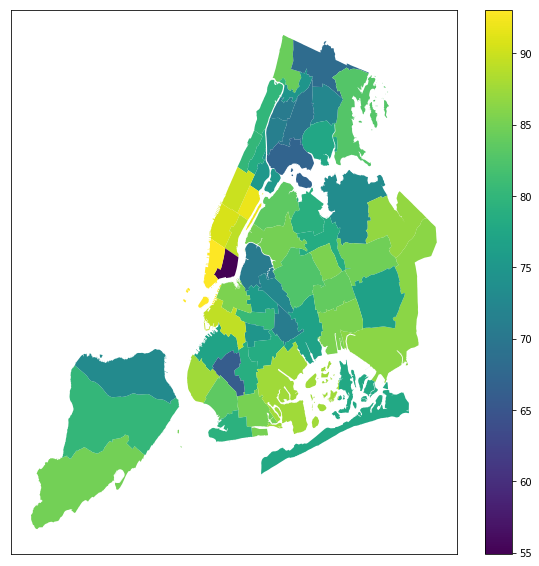

In [35]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(column='percentage_w_bb_access',alpha=1,linewidth=0.5,ax=ax, cmap='viridis', legend=True)

# Figure 2. Choropleth of NYC broadband access

In the graph, the legend shows what color corresponds for what percentage of households with broadband. For example, more than 90% of households have broadband access in the areas colored in yellow.  

We can see that Manhattan (less Lower East side) has generally high percentage of broadband access. Also, looks like the Bronx has less broadband access than other boroughs 

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW7_fb55 folder in :
https://github.com/fedhere/PUI2018_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [36]:
linkNYC = pd.read_csv(puidata + '/linkNYClocations.csv')

In [37]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [38]:
linkNYC.shape

(1414, 5)

In [39]:
# Create LinkNYC station Geometry (Point) from Coordinates (Lat & Lon)

import shapely
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [40]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [41]:
linkNYC_geo = linkNYC['geometry']

In [42]:
linkNYC = gpd.GeoDataFrame(linkNYC)

# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*


In [43]:
pumashp.crs = from_epsg(2263) 
linkNYC.crs = from_epsg(2263)

In [44]:
pumashp.crs

{'init': 'epsg:2263', 'no_defs': True}

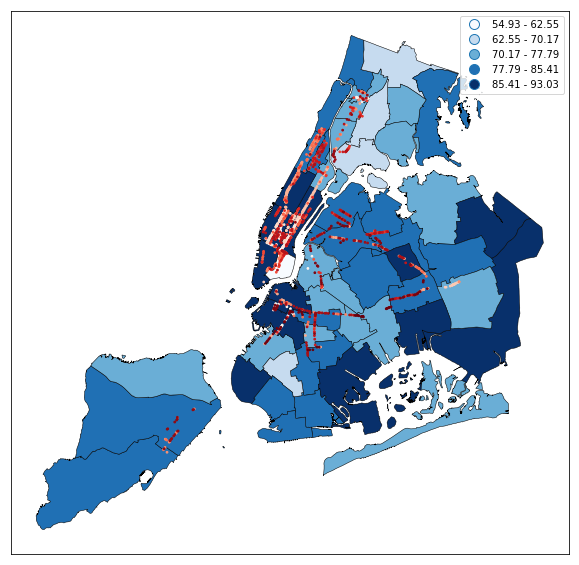

In [45]:
fig, ax = plt.subplots(1, figsize=(10,10))
pumashp.plot(column='percentage_w_bb_access',alpha=1,linewidth=0.5,ax=ax, cmap='Blues', scheme='Equal_interval', k=5, edgecolor='black', legend=True)
linkNYC.plot(ax=ax, cmap='Reds', markersize=3)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


## Figure 2. Location of the linkNYC stations on top of a choropleth of broadband access percentage (in 5 equal intervals)

The darker blue it is, the higher is the percent of families that has access to broadband. The redder the plots, the higher the number of linkNYC stations there are in that point.

The points are color coded the station by how long ago they have been installed (using the date datetime variable)

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [46]:
keyLPP = 'B00001_001E'
aff1y['variables'][keyLPP]

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyLPP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

In [47]:
pumashp = gpd.GeoDataFrame.from_file(puidata + '/geo_export_c0d36762-2ce4-4c96-ac35-cfeb8e0a58a2.shp')

In [48]:
# convert coordinates for pumashp and linkNYC
pumashp.crs = from_epsg(2263) 
linkNYC.crs = from_epsg(2263)

print(pumashp.crs)
print(linkNYC.crs)

{'init': 'epsg:2263', 'no_defs': True}
{'init': 'epsg:2263', 'no_defs': True}


create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [49]:
# need to make sure columns you are merging are the same type
pumaPop['public use microdata area'] = pumaPop['public use microdata area'].astype(int)

In [50]:
pumaPop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
B00001_001E                  145 non-null int64
NAME                         145 non-null object
state                        145 non-null int64
public use microdata area    145 non-null int64
Unnamed: 4                   0 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.7+ KB


In [51]:
linkpp = gpd.sjoin(linkNYC, pumashp, how = 'left', op='intersects').groupby('puma').count()
linkpp.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry,index_right,shape_area,shape_leng
puma,,,,,,,,,,
3701,1,1,1,1,1,1,1,1,1,1
3705,1,1,1,1,1,1,1,1,1,1
3706,20,20,20,20,20,20,20,20,20,20
3707,29,29,29,29,29,29,29,29,29,29
3708,19,19,19,19,19,19,19,19,19,19


In [52]:
linkpp.drop(['shape_area','shape_leng','geometry',
             'index_right','Unnamed: 0','longitude',
             'date_link_', 'latitude','lonlat'], axis=1,inplace=True)
linkpp.tail()

,link_site
puma,
4107,29
4108,24
4109,51
4111,40
4112,18


In [53]:
linkpp.reset_index(inplace=True)
linkpp.tail()

,puma,link_site
32,4107,29
33,4108,24
34,4109,51
35,4111,40
36,4112,18


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [54]:
pumashp = pumashp.merge(linkpp, on='puma', how='outer')
pumashp.tail()


,puma,shape_area,shape_leng,geometry,link_site
50,4111,1.326029e+08,56323.365530,POLYGON ((-73.82167849048575 40.71116601167973...,40.0
51,4112,2.600517e+08,72781.304161,POLYGON ((-73.75725671377032 40.71813860165978...,18.0
52,4113,1.714665e+08,110717.942782,(POLYGON ((-73.85722330984366 40.6502786705413...,NaN
53,4114,3.156828e+08,412606.741739,(POLYGON ((-73.83668274106707 40.5949466970158...,NaN
54,4009,3.470267e+08,379689.641465,(POLYGON ((-73.91513331918196 40.5862693854006...,NaN


In [55]:
pumaPop.tail()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
140,3259,"NYC-Queens Community District 5--Ridgewood, Gl...",36,4110,NaN
141,3124,NYC-Queens Community District 9--Richmond Hill...,36,4111,NaN
142,3940,"NYC-Queens Community District 12--Jamaica, Hol...",36,4112,NaN
143,2162,NYC-Queens Community District 10--Howard Beach...,36,4113,NaN
144,1559,NYC-Queens Community District 14--Far Rockaway...,36,4114,NaN


In [56]:
pumaPop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
B00001_001E                  145 non-null int64
NAME                         145 non-null object
state                        145 non-null int64
public use microdata area    145 non-null int64
Unnamed: 4                   0 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.7+ KB


In [57]:
pumashp['puma'] = pumashp['puma'].astype(int)
pumashp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 5 columns):
puma          55 non-null int64
shape_area    55 non-null float64
shape_leng    55 non-null float64
geometry      55 non-null object
link_site     37 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.6+ KB


In [58]:
pumashplc = pumaPop.merge(pumashp,left_on='public use microdata area', right_on='puma')

In [59]:
pumashplc.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,puma,shape_area,shape_leng,geometry,link_site
0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1.0
1,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",NaN
2,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,NaN
3,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",NaN
4,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,1.0


In [60]:
pumashplc["linkNYCp100p"] = pumashplc['link_site'] / pumashplc['B00001_001E'] * 100
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


In [61]:
pumashplc = gpd.GeoDataFrame(pumashplc)

pumashplc.crs = from_epsg(2263) 
print(pumashplc.crs)

{'init': 'epsg:2263', 'no_defs': True}


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


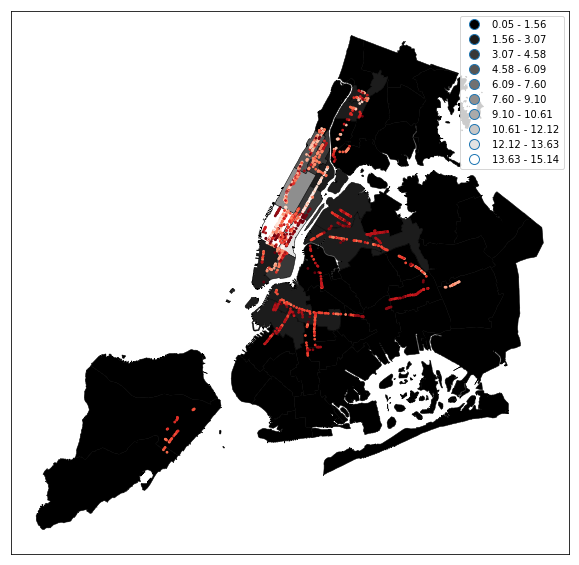

In [62]:
fig, ax = plt.subplots(1, figsize=(10,10))
pumashplc.plot(column='linkNYCp100p',alpha=1,linewidth=0.5,ax=ax, cmap='gist_gray', scheme='Equal_interval', edgecolor='black', k=10, legend=True)
linkNYC.plot(ax=ax, column='date_link_', cmap='Reds', markersize=3)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


## Figure 3:  Number of  linkNYC stations per 100 people 

The lighter the color of the map, the more linkNYC stations per 100 people  

